In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from model_structure import get_preprocessing_transforms,get_resnet_model,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Get transforms
train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

test_data_1_dir = 'data4model_1/test/'
test_data_2_dir = 'data4model_2/test/'
train_data_1_dir = 'data4model_1/train/'
train_data_2_dir = 'data4model_2/train/'

# Load data set
dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=val_transform)
dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=val_transform)
additional_set = datasets.ImageFolder('data4model_1/for_extra_test/',transform=val_transform)



additional_loader = DataLoader(additional_set, shuffle=False, batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

dataSets =  {"Model_1:Train": train_loader_1,
        "Model_1:Test": test_loader_1,
        "Model_2:Train": train_loader_2,
        "Model_2:Test": test_loader_2,
        "Model_1:additional_set": additional_loader
        }

In [15]:
# model_1_dir = 'my_models/best_model_1.pth'
# model_2_dir = 'my_models/best_model_2.pth'
model_info = "pretrained" # "my" or "new"
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [16]:
# Load the model
# model_1 = BCNN().to(DEVICE)
model_1 = get_resnet_model(2).to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

#model_2 = BCNN().to(DEVICE)
model_2 = get_resnet_model(2).to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_11960\1659288269.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9283333333333333
F1 Score:  0.9271926854046733
confusion Matrix: 
 [[1416   84]
 [ 131 1369]]


Model_1:Test
Accuracy:  0.87
F1 Score:  0.8617021276595744
confusion Matrix: 
 [[93  7]
 [19 81]]


Model_2:Train
Accuracy:  0.9436666666666667
F1 Score:  0.9452188006482982
confusion Matrix: 
 [[1373  127]
 [  42 1458]]


Model_2:Test
Accuracy:  0.89
F1 Score:  0.8981481481481481
confusion Matrix: 
 [[81 19]
 [ 3 97]]


Model_1:additional_set
Accuracy:  0.723422860712055
F1 Score:  0.7165172855313701
confusion Matrix: 
 [[2993 1007]
 [1207 2798]]




In [17]:
K_ROUND = 50  # Number of rounds to monitor
activation_values = {"Model_1":{},
                     "Model_2":{}}



In [18]:
activation_values = {"Model_1": {}, "Model_2": {}}

def register_hooks(model, model_name):
    activation_values[model_name] = {}
    hooks = []
    
    def get_hook(name):
        def hook(module, input, output):
            # Store input, output, weights and biases
            activation_values[model_name][name] = {
                'input': input[0].detach(),
                'output': output.detach(),
                'weight': module.weight.detach() if hasattr(module, 'weight') else None,
                'bias': module.bias.detach() if hasattr(module, 'bias') and module.bias is not None else None,
            }
            if isinstance(module, nn.Conv2d):
                activation_values[model_name][name]['conv_params'] = {
                    'kernel_size': module.kernel_size[0] if isinstance(module.kernel_size, tuple) else module.kernel_size,
                    'padding': module.padding[0] if isinstance(module.padding, tuple) else module.padding,
                    'stride': module.stride[0] if isinstance(module.stride, tuple) else module.stride,
                    'dilation': module.dilation[0] if isinstance(module.dilation, tuple) else module.dilation
                }
        return hook
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(get_hook(name)))
    
    return hooks

In [19]:
def select_random_neuron_indices(activations, n_neurons=1):
    indices = {}
    
    for layer_name, layer_data in activations.items():
        # skipping if layer without weight
        if not isinstance(layer_data, dict) or 'output' not in layer_data:
            continue
            
        # activation output and flatten it
        activation = layer_data['output']
        flattened = activation.view(activation.shape[0], -1)
        
        # positive (activated) indices
        positive_indices = np.where(flattened.cpu().numpy().squeeze() > 0)[0]
        
        # skipping if no activated neurons
        if len(positive_indices) == 0:
            continue
            
        # random neurons from activated ones
        selected_indices = np.random.choice(
            positive_indices,
            size=min(n_neurons, len(positive_indices)),
            replace=False
        )
        
        # storing selected indices
        indices[layer_name] = {
            'neuron_idx': selected_indices,
            'all_activated_indices': positive_indices,
            'original_shape': activation.shape
        }
    
    return indices

In [20]:
def compare_model_activations(model1_activations, model2_activations, selected_indices):
    comparison_results = {}
    
    for layer_name, indices_info in selected_indices.items():
        if layer_name not in model1_activations or layer_name not in model2_activations:
            continue
        
        data1 = model1_activations[layer_name]
        data2 = model2_activations[layer_name]
        
        if not isinstance(data1, dict) or not isinstance(data2, dict):
            continue
        
        selected_indices = indices_info['neuron_idx']
        original_shape = indices_info.get('original_shape', data1['output'].shape)
        
        # get inputs, weights, biases, and stored outputs
        input1 = data1['input']
        weights1 = data1['weight']
        bias1 = data1.get('bias')
        weights2 = data2['weight']
        bias2 = data2.get('bias')
        stored_output1 = data1['output']
    
        layer_results = {
            'neuron_comparisons': [],
            'model1_verification_errors': [],
            'cross_model_differences': []
        }
        
        for idx in selected_indices:
            if len(weights1.shape) == 4:
                # dimensions: batch_size, channels, height, width
                batch_size, channels, height, width = original_shape
                
                # converting flat idx to corresponding coordinates
                channel = idx // (height * width)
                pos_in_channel = idx % (height * width)
                h_idx = pos_in_channel // width
                w_idx = pos_in_channel % width
                
                # remove try it is for debugging
                if channel >= stored_output1.shape[1]:
                    continue
                
                # get stored activation for this position
                stored_activation = stored_output1[0, channel, h_idx, w_idx].item()
                
                
                ####################################
                # check if it is correct because of hyperparameters of conv.
                ####################################
                # get convolution parameters
                kernel_size = weights1.shape[2]
                padding = kernel_size // 2  # symmetric padding
                
                # get input patch that corresponds to this position
                if '1'=='2':#DEBUG
                    #DEBUG
                    in_h_start = max(0, h_idx - padding) #DEBUG
                    in_w_start = max(0, w_idx - padding)#DEBUG
                    in_h_end = min(input1.shape[2], h_idx + kernel_size - padding)#DEBUG
                    in_w_end = min(input1.shape[3], w_idx + kernel_size - padding)#DEBUG
                    input_patch = input1[0, :, in_h_start:in_h_end, in_w_start:in_w_end]#DEBUG
                else:
                    conv_params = data1.get('conv_params', {
                        'kernel_size': 3, 
                        'padding': 1,
                        'stride': 1,
                        'dilation': 1
                    })
                    
                    kernel_size = conv_params['kernel_size']
                    padding = conv_params['padding']
                    stride = conv_params['stride']
                    dilation = conv_params['dilation']
                    
                    # Calculate input patch position
                    # With padding=1, we need to adjust the position to get the correct patch
                    in_h_start = h_idx * stride - padding
                    in_w_start = w_idx * stride - padding
                    in_h_end = in_h_start + kernel_size
                    in_w_end = in_w_start + kernel_size
                    
                    # Extract the input patch accounting for padding
                    input_patch = torch.zeros(input1.shape[1], kernel_size, kernel_size, device=input1.device)
                    
                    for i in range(kernel_size):
                        for j in range(kernel_size):
                            h_pos = in_h_start + i * dilation
                            w_pos = in_w_start + j * dilation
                            
                            # If position is within bounds of input
                            if 0 <= h_pos < input1.shape[2] and 0 <= w_pos < input1.shape[3]:
                                input_patch[:, i, j] = input1[0, :, h_pos, w_pos]

                ####################################

                # compute expected activation with model1 weights so i will be sure that my calculation is correct
                if channel < weights1.shape[0]:
                    kernel1 = weights1[channel]
                    # classic convolution calculation
                    calculated_activation1 = (input_patch * kernel1).sum()
                    
                    if bias1 is not None:
                        calculated_activation1 += bias1[channel]

                    calculated_activation1 = max(0, calculated_activation1.item())  # ReLU
                else:
                    calculated_activation1 = 0
                
                # compute activation using model2 weights with model1 input
                if channel < weights2.shape[0]:
                    kernel2 = weights2[channel]
                    calculated_activation2 = (input_patch * kernel2).sum()
                    if bias2 is not None:
                        calculated_activation2 += bias2[channel]
                    calculated_activation2 = max(0, calculated_activation2.item())  # ReLU
                else:
                    calculated_activation2 = 0
                
                neuron_data = {
                    'type': 'conv',
                    'position': {'channel': int(channel), 'height': int(h_idx), 'width': int(w_idx)},
                    'input_patch': {
                        'data': input_patch.detach().cpu().numpy(),
                        'coords': {'h_start': in_h_start, 'h_end': in_h_end, 
                                  'w_start': in_w_start, 'w_end': in_w_end}
                    }
                }
            else:
                
                flattened_output = stored_output1.view(stored_output1.shape[0], -1)
                
                # check if it is correct when i remove this
                if idx >= flattened_output.shape[1] or idx >= weights1.shape[0]:
                    continue
                
                # get stored activation
                stored_activation = flattened_output[0, idx].item()
                
                # unrolling input for dot product
                flattened_input = input1.flatten(start_dim=1)
                
                 # check if it is correct when i remove this
                if flattened_input.shape[1] != weights1.shape[1]:
                    continue
                
                # calculate model1 activation
                calculated_activation1 = torch.matmul(flattened_input, weights1[idx])
                if bias1 is not None and idx < bias1.shape[0]:
                    calculated_activation1 += bias1[idx]
                calculated_activation1 = max(0, calculated_activation1.item())  # ReLU
                
                # Calculate using model2 weights with model1 input
                calculated_activation2 = torch.matmul(flattened_input, weights2[idx])
                if bias2 is not None and idx < bias2.shape[0]:
                    calculated_activation2 += bias2[idx]
                calculated_activation2 = max(0, calculated_activation2.item())  # ReLU
                
                neuron_data = {
                    'type': 'linear',
                    'position': {'neuron': int(idx)},
                    'input_values': flattened_input.detach().cpu().numpy()
                }
            
            # Calculate verification error (how accurate our calculation is)
            verification_error = abs(stored_activation - calculated_activation1)
            
            # Calculate cross-model difference
            cross_model_difference = abs(calculated_activation1 - calculated_activation2)
            
            # Store comparison for this neuron
            neuron_comparison = {
                'neuron_idx': int(idx),
                'stored_activation': stored_activation,
                'calculated_activation1': calculated_activation1,
                'calculated_activation2': calculated_activation2,
                'verification_error': verification_error,
                'cross_model_difference': cross_model_difference,
                'neuron_data': neuron_data
            }
            
            layer_results['neuron_comparisons'].append(neuron_comparison)
            layer_results['model1_verification_errors'].append(verification_error)
            layer_results['cross_model_differences'].append(cross_model_difference)
        
        # Calculate statistics
        if layer_results['neuron_comparisons']:
            layer_results['mean_verification_error'] = sum(layer_results['model1_verification_errors']) / len(layer_results['model1_verification_errors'])
            layer_results['mean_cross_model_difference'] = sum(layer_results['cross_model_differences']) / len(layer_results['cross_model_differences'])
        else:
            layer_results['mean_verification_error'] = float('nan')
            layer_results['mean_cross_model_difference'] = float('nan')
        
        comparison_results[layer_name] = layer_results
    
    return comparison_results

In [21]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [22]:
the_class = 1 # 0 cat or squirrel, 1 dog

In [23]:
activation_values = {"Model_1":{},
                    "Model_2":{}}

In [24]:
images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
            if label == the_class  and model_1(img.unsqueeze(0).to(DEVICE))
                                          .argmax().item() == the_class]


In [71]:
layer_stats_columns = [
    'image_id', 'round', 'layer_name', 
    'mean_verification_error', 'mean_cross_model_difference',
]
layer_stats_df = pd.DataFrame(columns=layer_stats_columns)
for image, pic_index in images:
    for i in range(K_ROUND):        
        # register hooks
        hooks1 = register_hooks(model_1, "Model_1")
        hooks2 = register_hooks(model_2, "Model_2")
        
        # clearing
        activation_values["Model_1"] = {}
        activation_values["Model_2"] = {}
        
        # Forward pass
        with torch.no_grad():
            pred1 = model_1(image.unsqueeze(0).to(DEVICE))
            pred2 = model_2(image.unsqueeze(0).to(DEVICE))
        
        # Select random neurons and compare
        selected_indices = select_random_neuron_indices(
            activation_values["Model_1"], 
            n_neurons=1
        )
        result = compare_model_activations(
            activation_values["Model_1"], 
            activation_values["Model_2"], 
            selected_indices
        )
        
        # Process results for each layer
        for layer_name, layer_data in result.items():
            layer_stats_df = pd.concat([layer_stats_df, pd.DataFrame({
                'image_id': [pic_index],
                'round': [i],
                'layer_name': [layer_name],
                'mean_verification_error': [layer_data.get('mean_verification_error', np.nan)],
                'mean_cross_model_difference': [layer_data.get('mean_cross_model_difference', np.nan)]
            })], ignore_index=True)
        
        print('\r ',f"pic_index: {pic_index:02d}", f"round: {i:02d}",end="\n")
        # Remove hooks
        for hook in hooks1 + hooks2:
            hook.remove()


C:\Users\hskay\AppData\Local\Temp\ipykernel_10604\1745977535.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  layer_stats_df = pd.concat([layer_stats_df, pd.DataFrame({


  pic_index: 100 round: 00
  pic_index: 100 round: 01
  pic_index: 100 round: 02
  pic_index: 100 round: 03
  pic_index: 100 round: 04
  pic_index: 100 round: 05
  pic_index: 100 round: 06
  pic_index: 100 round: 07
  pic_index: 100 round: 08
  pic_index: 100 round: 09
  pic_index: 100 round: 10
  pic_index: 100 round: 11
  pic_index: 100 round: 12
  pic_index: 100 round: 13
  pic_index: 100 round: 14
  pic_index: 100 round: 15
  pic_index: 100 round: 16
  pic_index: 100 round: 17
  pic_index: 100 round: 18
  pic_index: 100 round: 19
  pic_index: 100 round: 20
  pic_index: 100 round: 21
  pic_index: 100 round: 22
  pic_index: 100 round: 23
  pic_index: 100 round: 24
  pic_index: 100 round: 25
  pic_index: 100 round: 26
  pic_index: 100 round: 27
  pic_index: 100 round: 28
  pic_index: 100 round: 29
  pic_index: 100 round: 30
  pic_index: 100 round: 31
  pic_index: 100 round: 32
  pic_index: 100 round: 33
  pic_index: 100 round: 34
  pic_index: 100 round: 35
  pic_index: 100 round: 36
 

In [ ]:
layer_stats_df.to_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv', index=False)

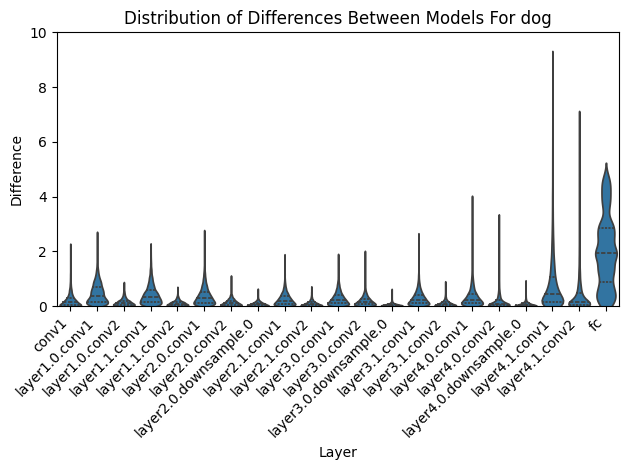

Minimum values for each layer:
conv1: 0.000000e+00
layer1.0.conv1: 4.690886e-05
layer1.0.conv2: 2.777576e-05
layer1.1.conv1: 3.135204e-04
layer1.1.conv2: 1.438335e-05
layer2.0.conv1: 0.000000e+00
layer2.0.conv2: 1.430511e-06
layer2.0.downsample.0: 1.564622e-05
layer2.1.conv1: 1.978874e-05
layer2.1.conv2: 3.029406e-05
layer3.0.conv1: 6.625056e-05
layer3.0.conv2: 3.886223e-05
layer3.0.downsample.0: 8.728355e-06
layer3.1.conv1: 1.667142e-04
layer3.1.conv2: 8.091703e-05
layer4.0.conv1: 2.950802e-05
layer4.0.conv2: 0.000000e+00
layer4.0.downsample.0: 2.674758e-06
layer4.1.conv1: 1.281500e-05
layer4.1.conv2: 2.484070e-05
fc: 5.288959e-03


In [25]:
layer_stats_df = pd.read_csv(f'{model_info}_model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')
# Create violin plot
sns.violinplot(data=layer_stats_df, 
                x='layer_name', 
                y='mean_cross_model_difference',
                inner='quartile',
                density_norm='count')
# density_norm{“area”, “count”, “width”}
# Method that normalizes each density to determine the violin’s width. 
# If area, each violin will have the same area. If count, 
# the width will be proportional to the number of observations. 
# If width, each violin will have the same width.

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Differences Between Models For {classes[the_class]}')
plt.xlabel('Layer')
plt.ylabel('Difference')
#plt.yscale('log')
plt.ylim(0, 1e1)

# Adjust layout
plt.tight_layout()

# Save plot
save_path = f'{model_info}_model_differences_violin_plot_for_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print("Minimum values for each layer:")
for layer in layer_stats_df['layer_name'].unique():
    min_value = layer_stats_df[layer_stats_df['layer_name'] == layer]['mean_cross_model_difference'].min()
    print(f"{layer}: {min_value:.6e}")

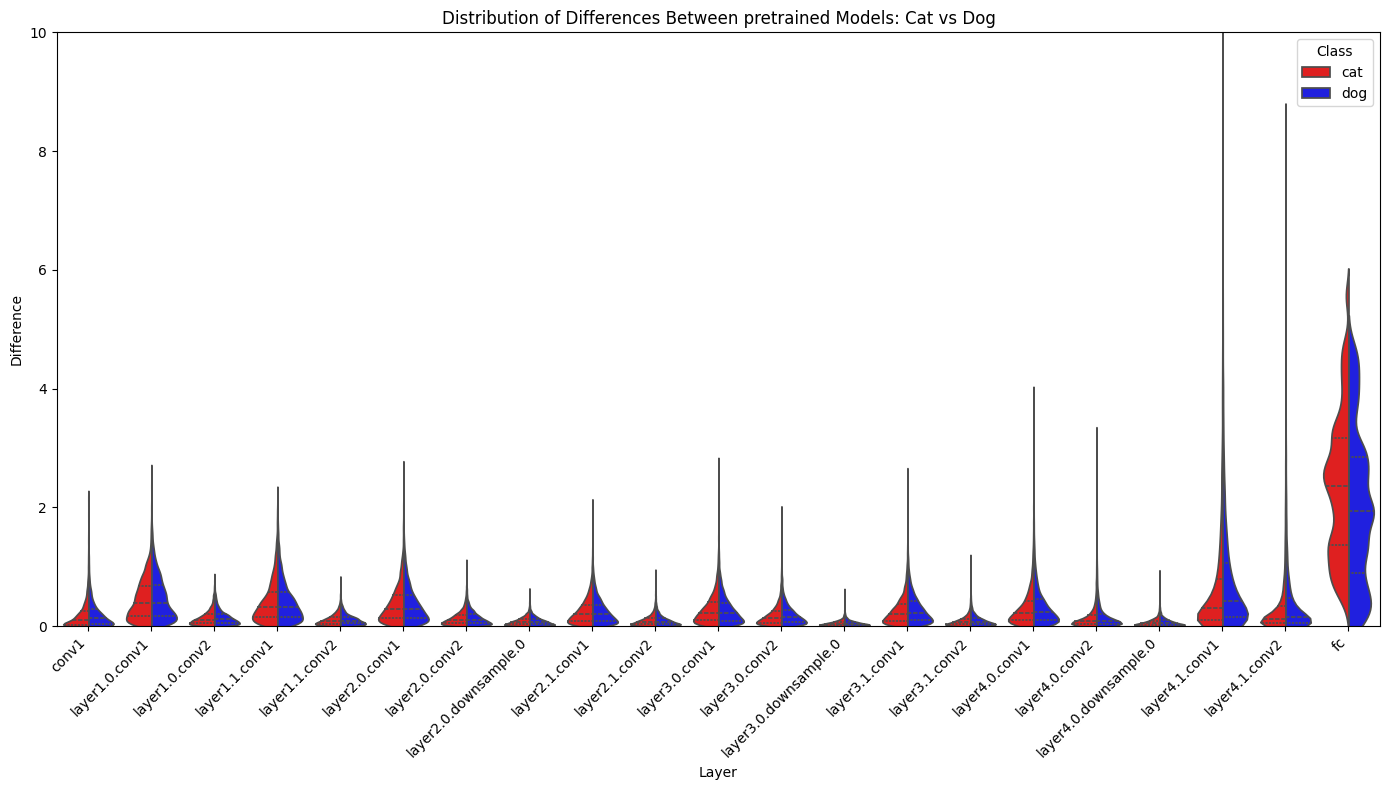

Minimum values for each layer:
conv1: 0.000000e+00
layer1.0.conv1: 4.768372e-07
layer1.0.conv2: 2.777576e-05
layer1.1.conv1: 3.802776e-05
layer1.1.conv2: 2.130866e-06
layer2.0.conv1: 0.000000e+00
layer2.0.conv2: 0.000000e+00
layer2.0.downsample.0: 1.564622e-05
layer2.1.conv1: 0.000000e+00
layer2.1.conv2: 4.000962e-06
layer3.0.conv1: 6.625056e-05
layer3.0.conv2: 3.886223e-05
layer3.0.downsample.0: 8.728355e-06
layer3.1.conv1: 0.000000e+00
layer3.1.conv2: 7.078052e-07
layer4.0.conv1: 1.943856e-05
layer4.0.conv2: 0.000000e+00
layer4.0.downsample.0: 2.674758e-06
layer4.1.conv1: 1.281500e-05
layer4.1.conv2: 6.156741e-06
fc: 5.288959e-03


In [ ]:
cat_df = pd.read_csv(f'{model_info}_model_random_paths_for_cat_and_{K_ROUND}_Rounds.csv')
dog_df = pd.read_csv(f'{model_info}_model_random_paths_for_dog_and_{K_ROUND}_Rounds.csv')

cat_df['class'] = 'cat'
dog_df['class'] = 'dog'

combined_df = pd.concat([cat_df, dog_df], ignore_index=True)

plt.figure(figsize=(14, 8))
sns.violinplot(data=combined_df, 
               x='layer_name', 
               y='mean_cross_model_difference',
               hue='class',
               inner='quartile',
               density_norm='count',
               split=True,
               palette={'cat': 'red', 'dog': 'blue'})

plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Differences Between {model_info} Models: Cat vs Dog')
plt.xlabel('Layer')
plt.ylabel('Difference')
plt.ylim(0, 1e0)
plt.legend(title='Class')
plt.tight_layout()

save_path = f'{model_info}_model_differences_violin_plot_cat_vs_dog_{K_ROUND}_rounds.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print("Minimum values for each layer:")
for layer in combined_df['layer_name'].unique():
    min_value = combined_df[combined_df['layer_name'] == layer]['mean_cross_model_difference'].min()
    print(f"{layer}: {min_value:.6e}")


KL Divergence Analysis Between Cat and Dog Distributions:
--------------------------------------------------------
Layer conv1:
  KL(cat||dog): 0.0076
  KL(dog||cat): 0.0085
  Symmetric KL: 0.0080
Layer layer1.0.conv1:
  KL(cat||dog): 0.0054
  KL(dog||cat): 0.0093
  Symmetric KL: 0.0073
Layer layer1.0.conv2:
  KL(cat||dog): 0.0045
  KL(dog||cat): 0.0045
  Symmetric KL: 0.0045
Layer layer1.1.conv1:
  KL(cat||dog): 0.0046
  KL(dog||cat): 0.0044
  Symmetric KL: 0.0045
Layer layer1.1.conv2:
  KL(cat||dog): 0.0110
  KL(dog||cat): 0.0135
  Symmetric KL: 0.0123
Layer layer2.0.conv1:
  KL(cat||dog): 0.0034
  KL(dog||cat): 0.0131
  Symmetric KL: 0.0083
Layer layer2.0.conv2:
  KL(cat||dog): 0.0076
  KL(dog||cat): 0.0146
  Symmetric KL: 0.0111
Layer layer2.0.downsample.0:
  KL(cat||dog): 0.0018
  KL(dog||cat): 0.0091
  Symmetric KL: 0.0055
Layer layer2.1.conv1:
  KL(cat||dog): 0.0265
  KL(dog||cat): 0.0065
  Symmetric KL: 0.0165
Layer layer2.1.conv2:
  KL(cat||dog): 0.0131
  KL(dog||cat): 0.0036

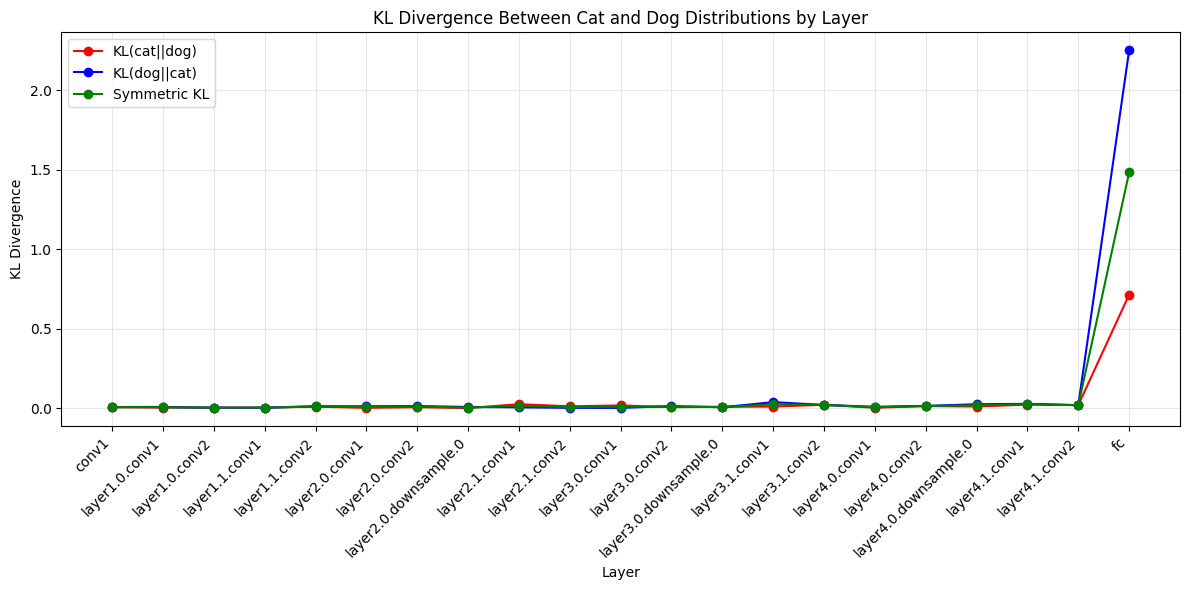

In [31]:
import numpy as np
from scipy.stats import entropy

# Function to calculate KL divergence between two sample sets
def calculate_kl_divergence(p_samples, q_samples, bins=20, eps=1e-10):
    min_val = min(np.min(p_samples), np.min(q_samples))
    max_val = max(np.max(p_samples), np.max(q_samples))
    bin_edges = np.linspace(min_val, max_val, bins+1)

    p_hist, _ = np.histogram(p_samples, bins=bin_edges, density=True)
    q_hist, _ = np.histogram(q_samples, bins=bin_edges, density=True)
    
    p_hist = p_hist + eps
    q_hist = q_hist + eps

    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)

    kl_div = entropy(p_hist, q_hist)
    
    return kl_div

# Calculate KL divergence for each layer
print("\nKL Divergence Analysis Between Cat and Dog Distributions:")
print("--------------------------------------------------------")
kl_divergences = []
for layer in combined_df['layer_name'].unique():
    cat_values = combined_df[(combined_df['layer_name'] == layer) & (combined_df['class'] == 'cat')]['mean_cross_model_difference']
    dog_values = combined_df[(combined_df['layer_name'] == layer) & (combined_df['class'] == 'dog')]['mean_cross_model_difference']
    
    #KL(cat dog) and KL(dog cat)
    kl_cat_dog = calculate_kl_divergence(cat_values, dog_values)
    kl_dog_cat = calculate_kl_divergence(dog_values, cat_values)
    
    kl_divergences.append({
        'layer_name': layer,
        'KL(cat||dog)': kl_cat_dog,
        'KL(dog||cat)': kl_dog_cat,
        'symmetric_KL': (kl_cat_dog + kl_dog_cat) / 2  # Symmetric KL
    })
    
    print(f"Layer {layer}:")
    print(f"  KL(cat||dog): {kl_cat_dog:.4f}")
    print(f"  KL(dog||cat): {kl_dog_cat:.4f}")
    print(f"  Symmetric KL: {(kl_cat_dog + kl_dog_cat) / 2:.4f}")

kl_df = pd.DataFrame(kl_divergences)

# Visualize the KL divergence
plt.figure(figsize=(12, 6))
plt.plot(kl_df['layer_name'], kl_df['KL(cat||dog)'], 'r-o', label='KL(cat||dog)')
plt.plot(kl_df['layer_name'], kl_df['KL(dog||cat)'], 'b-o', label='KL(dog||cat)')
plt.plot(kl_df['layer_name'], kl_df['symmetric_KL'], 'g-o', label='Symmetric KL')
plt.xticks(rotation=45, ha='right')
plt.title(f'KL Divergence Between Cat and Dog Distributions by Layer')
plt.xlabel('Layer')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

kl_save_path = f'{model_info}_kl_divergence_cat_vs_dog_{K_ROUND}_rounds.png'
plt.savefig(kl_save_path, dpi=300, bbox_inches='tight')
plt.show()


In [30]:
for i in combined_df:
    print(i)

image_id
round
layer_name
mean_verification_error
mean_cross_model_difference
class
